In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        TabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    # agents[0] = TitForTat()
    # agents[16] = TitForTat()
    # agents[16] = TitForTat()
    # agents[31] = TitForTat()

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/50000 [00:00<?, ?it/s]

BEST AGENT: 354274 (0.7198984813131933, CDCDCDCDCCDDCCCC)
WORST AGENT: 177182 (0.7312877731287774, CDDDDDCDDDCCDDCC)


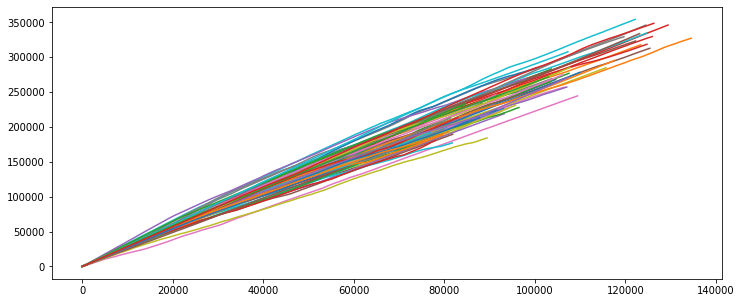

In [7]:
POPULATION = (16, 4)
ROUNDS = 50_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

In [8]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [9]:
sim.calculate_weights()

[[0.6005036440125614, 0.5950528946557568, 0.5460459139374153],
 [0.6165228676488259, 0.6297173732335827],
 [0.6005036440125614, 0.6165228676488259, 0.5776916817039947],
 [0.5950528946557568,
  0.6297173732335827,
  0.5776916817039947,
  0.6063312284921987],
 [0.6063312284921987, 0.6068454401448291, 0.49489632009345796],
 [0.5644803737461641, 0.5016233946739311],
 [0.6068454401448291, 0.5644803737461641, 0.5479785538327778],
 [0.49489632009345796,
  0.5016233946739311,
  0.5479785538327778,
  0.5911333310106958],
 [0.5911333310106958, 0.6132811573579983, 0.6794700894182861],
 [0.5931757851957997, 0.6378069085815471],
 [0.6132811573579983, 0.5931757851957997, 0.5585205363144302],
 [0.6794700894182861,
  0.6378069085815471,
  0.5585205363144302,
  0.43645067913604985],
 [0.43645067913604985, 0.5076444714090702, 0.480285644102888],
 [0.8352346146315995, 0.5700088290475664],
 [0.5076444714090702, 0.8352346146315995, 0.6012456402590931],
 [0.480285644102888,
  0.5700088290475664,
  0.6012456

In [10]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE:

In [11]:
cumulative_rewards[0][0]

59

In [12]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[137.3657972  135.16015598]
  [135.13483013 135.16007743]
  [133.24742    133.09351645]
  [133.18110229 133.37693547]]

 [[135.11085394 134.03940929]
  [134.87472498 135.8101637 ]
  [132.97853763 132.73081651]
  [133.50318299 134.06397974]]

 [[134.25321797 134.17402864]
  [135.20946395 135.00021199]
  [135.02438064 135.10538563]
  [132.73800375 132.95896343]]

 [[137.3320435  137.26925603]
  [133.56867917 133.21538308]
  [134.73907471 134.69996783]
  [135.04647518 133.52499307]]]


In [13]:
agents[1]._q_table

array([[[113.24289918, 122.1053885 ],
        [119.91465128, 123.84838934],
        [120.64263741, 108.73676279],
        [120.43000805, 109.43771549]],

       [[120.64023759, 112.06064584],
        [106.13489727, 114.52214299],
        [121.67250765, 119.90867101],
        [113.95835232, 121.72828076]],

       [[121.73954311, 117.89877514],
        [118.89427042, 123.42874143],
        [119.85798657,  99.42403195],
        [119.93760509, 106.27148781]],

       [[120.80360294, 106.6614347 ],
        [112.44465788, 123.3225482 ],
        [120.80014387,  84.26909104],
        [120.23607755,  73.21290661]]])

In [14]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [15]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [16]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      CDCDCDCDCCDDCCCC
2.0                      CDDDDDCDDDCCDCDC
3.0                      DDCDCCCDCDCCCCCC
4.0                      DCCDDCCCDDCDDDCD
5.0                      CCCDCDCDCCDDCCCD
6.0                      CDCCCDCDCDCDCCDC
7.0                      CDCDCDCCCDCCDCCC
8.0                      CDDCDCDCDDDDCCDC
9.0                      CDDDCDDDCDDDDDCD
10.0                     CDCCCDCDDDCCDDDC
11.0                     CDCDCDCDCDCDCDCD
12.0                     CDCCCDCCCDCCCDCC
13.0                     CDCCCDCDCCDDCCCD
14.0                     CDCCCCCDCDCCDDCD
15.0                     CDCDCDCDCDCDDDCC
16.0                     CDCDCDCDCCCCCCCC
17.0                     DCCCDDCDDDCCDDDC
18.0                     DDCDCDCDCDCDDCCD
19.0                     DCCDDDCCDCCDDCCC
20.0                     CDDCCDDDDDDCDCDC
22.0                     CDCCCDCCCDCCDCCC
23.0                     CDCDCDCDDCCCCDCC
24.0                     DDCDDDCDDDCCDCCD
25.0                     CDCDCDCDD

In [17]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

354274.0                 CDCDCDCDCCDDCCCC
348622.0                 CDDDDDCDDDCCDCDC
346138.0                 DDCDCCCDCDCCCCCC
346056.0                 DCCDDCCCDDCDDDCD
334668.0                 CCCDCDCDCCDDCCCD
333764.0                 CDCCCDCDCDCDCCDC
329589.0                 CDCDCDCCCDCCDCCC
329326.0                 CDDCDCDCDDDDCCDC
327183.0                 CDDDCDDDCDDDDDCD
323317.0                 CDCCCDCDDDCCDDDC
318547.0                 CDCDCDCDCDCDCDCD
317729.0                 CDCCCDCCCDCCCDCC
312773.0                 CDCCCDCDCCDDCCCD
307780.0                 CDCCCCCDCDCCDDCD
295422.0                 CDCDCDCDCDCDDDCC
285149.0                 CDCDCDCDCCCCCCCC
284886.0                 DCCCDDCDDDCCDDDC
284135.0                 DDCDCDCDCDCDDCCD
283181.0                 DCCDDDCCDCCDDCCC
278366.0                 CDDCCDDDDDDCDCDC
276896.0                 CDCCCDCCCDCCDCCC
274847.0                 CDCDCDCDDCCCCDCC
271805.0                 DDCDDDCDDDCCDCCD
271155.0                 CDCDCDCDD

In [18]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CDCDCDCDCCDDCCCC'

In [19]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    agents[cumulative_rewards[0][0]]._q_table

In [20]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => D
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => D
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => D
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => D
('(D, C)', '(D, D)') => D
('(D, D)', '(C, C)') => C
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
